# Лабораторная работа №3
Выполнила Фонград Анастасия КИ21-16/1б

In [97]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, Lars, BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import warnings
from math import log
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.neighbors import KNeighborsRegressor
from typing import Union
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [60]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [61]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         808 non-null    int64  
 1   Количество.комнат          808 non-null    int64  
 2   Студия                     808 non-null    int64  
 3   Общая.площадь              808 non-null    float64
 4   Этаж                       808 non-null    int64  
 5   Этажей.в.доме              808 non-null    int64  
 6   Парковка                   808 non-null    int64  
 7   Без.ремонта                808 non-null    int64  
 8   Дизайнерский               808 non-null    int64  
 9   Евроремонт                 808 non-null    int64  
 10  Косметический              808 non-null    int64  
 11  Балкон                     808 non-null    int64  
 12  Лоджия                     808 non-null    int64  
 13  Совмещенный.санузел        808 non-null    int64  

## Предварительная обработка данных

In [62]:
train_data.drop("id", axis=1, inplace=True)
test_data.drop("id", axis=1, inplace=True)
answer = 'Цена'

In [63]:
train_data.describe()

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,Косметический,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,8.080000e+02
mean,2.039604,0.040842,50.781176,4.894802,8.935644,0.142327,0.101485,0.024752,0.101485,0.772277,...,10.372525,4.674505,0.143564,7.788366,2.501238,13.263614,4.149752,6.754950,13.470297,2.699083e+06
std,0.996109,0.198046,19.827507,3.760826,4.754526,0.349601,0.302157,0.155466,0.302157,0.419622,...,15.397133,3.255991,0.378064,8.983450,1.636025,7.557860,5.955523,6.873569,8.068579,1.096460e+06
min,1.000000,0.000000,10.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.990000e+05
25%,1.000000,0.000000,37.650000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.000000,2.000000,0.000000,3.000000,1.000000,8.000000,1.000000,2.000000,7.000000,1.950000e+06
50%,2.000000,0.000000,48.000000,4.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,4.000000,4.000000,0.000000,6.000000,2.000000,13.000000,3.000000,5.000000,12.000000,2.550000e+06
75%,3.000000,0.000000,63.075000,6.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,12.000000,7.000000,0.000000,9.000000,4.000000,18.000000,5.000000,10.000000,19.000000,3.310000e+06
max,5.000000,1.000000,120.000000,24.000000,26.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,86.000000,14.000000,2.000000,67.000000,8.000000,42.000000,52.000000,40.000000,40.000000,6.800000e+06


Можно увидеть, что категориальные признаки уже были закодированы. Для избежания ловушки фиктивных переменных были удалены некоторые колонки

In [64]:
train_data.drop("Без.ремонта", axis=1, inplace=True)
train_data.drop("Совмещенный.санузел", axis=1, inplace=True)
train_data.drop("Смешанные.стены", axis=1, inplace=True)
train_data.drop("Иные.перекрытия", axis=1, inplace=True)

Получим список всех числовых признаков. Числовыми будем считать признаки с более чем 5 уникальными значениями

In [65]:
numeric = []
categorical = []
for name in train_data.columns:
    if train_data[name].nunique() > 5:
        numeric.append(name)
    else:
        categorical.append(name)
numeric.remove(answer)
columns = numeric + categorical
print(numeric)
print(categorical)

['Общая.площадь', 'Этаж', 'Этажей.в.доме', 'Год.постройки', 'Школа.1000', 'ВУЗ.1000', 'ТЦ.1000', 'Стоматология.1000', 'Почта.1000', 'Поликлиника.1000', 'Остановка.1000', 'Одежда..1000', 'Супер3кет.1000', 'Кафе.1000', 'АЗС.1000', 'Детский.сад.1000', 'Бар.1000', 'Банк.1000', 'Аптека.1000']
['Количество.комнат', 'Студия', 'Парковка', 'Дизайнерский', 'Евроремонт', 'Косметический', 'Балкон', 'Лоджия', 'Раздельный.санузел', 'Лифт', 'Грузовой.лифт', 'Мусоропровод', 'Аварийный', 'Железобетонные.перекрытия', 'Смешанные.перекрытия', 'Деревянные.перекрытия', 'Панельные.стены', 'Блочные.стены', 'Деревянные.стены', 'Кирпичные.стены', 'Монолитные.стены', 'Парк.1000', 'Кинотеатр.1000']


Нормализуем числовые признаки

In [66]:
scaler = MinMaxScaler()
train_data[numeric] = scaler.fit_transform(train_data[numeric])
test_data[numeric] = scaler.fit_transform(test_data[numeric])
train_data.describe()

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Дизайнерский,Евроремонт,Косметический,Балкон,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,8.080000e+02
mean,2.039604,0.040842,0.370738,0.169339,0.288985,0.142327,0.024752,0.101485,0.772277,0.632426,...,0.120611,0.333893,0.143564,0.116244,0.312655,0.315800,0.079803,0.168874,0.336757,2.699083e+06
std,0.996109,0.198046,0.180250,0.163514,0.198105,0.349601,0.155466,0.302157,0.419622,0.635417,...,0.179036,0.232571,0.378064,0.134081,0.204503,0.179949,0.114529,0.171839,0.201714,1.096460e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.990000e+05
25%,1.000000,0.000000,0.251364,0.043478,0.125000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.023256,0.142857,0.000000,0.044776,0.125000,0.190476,0.019231,0.050000,0.175000,1.950000e+06
50%,2.000000,0.000000,0.345455,0.130435,0.291667,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.046512,0.285714,0.000000,0.089552,0.250000,0.309524,0.057692,0.125000,0.300000,2.550000e+06
75%,3.000000,0.000000,0.482500,0.217391,0.333333,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.139535,0.500000,0.000000,0.134328,0.500000,0.428571,0.096154,0.250000,0.475000,3.310000e+06
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.800000e+06


## Отбор информативных признаков
Построим матрицы корреляции признаков

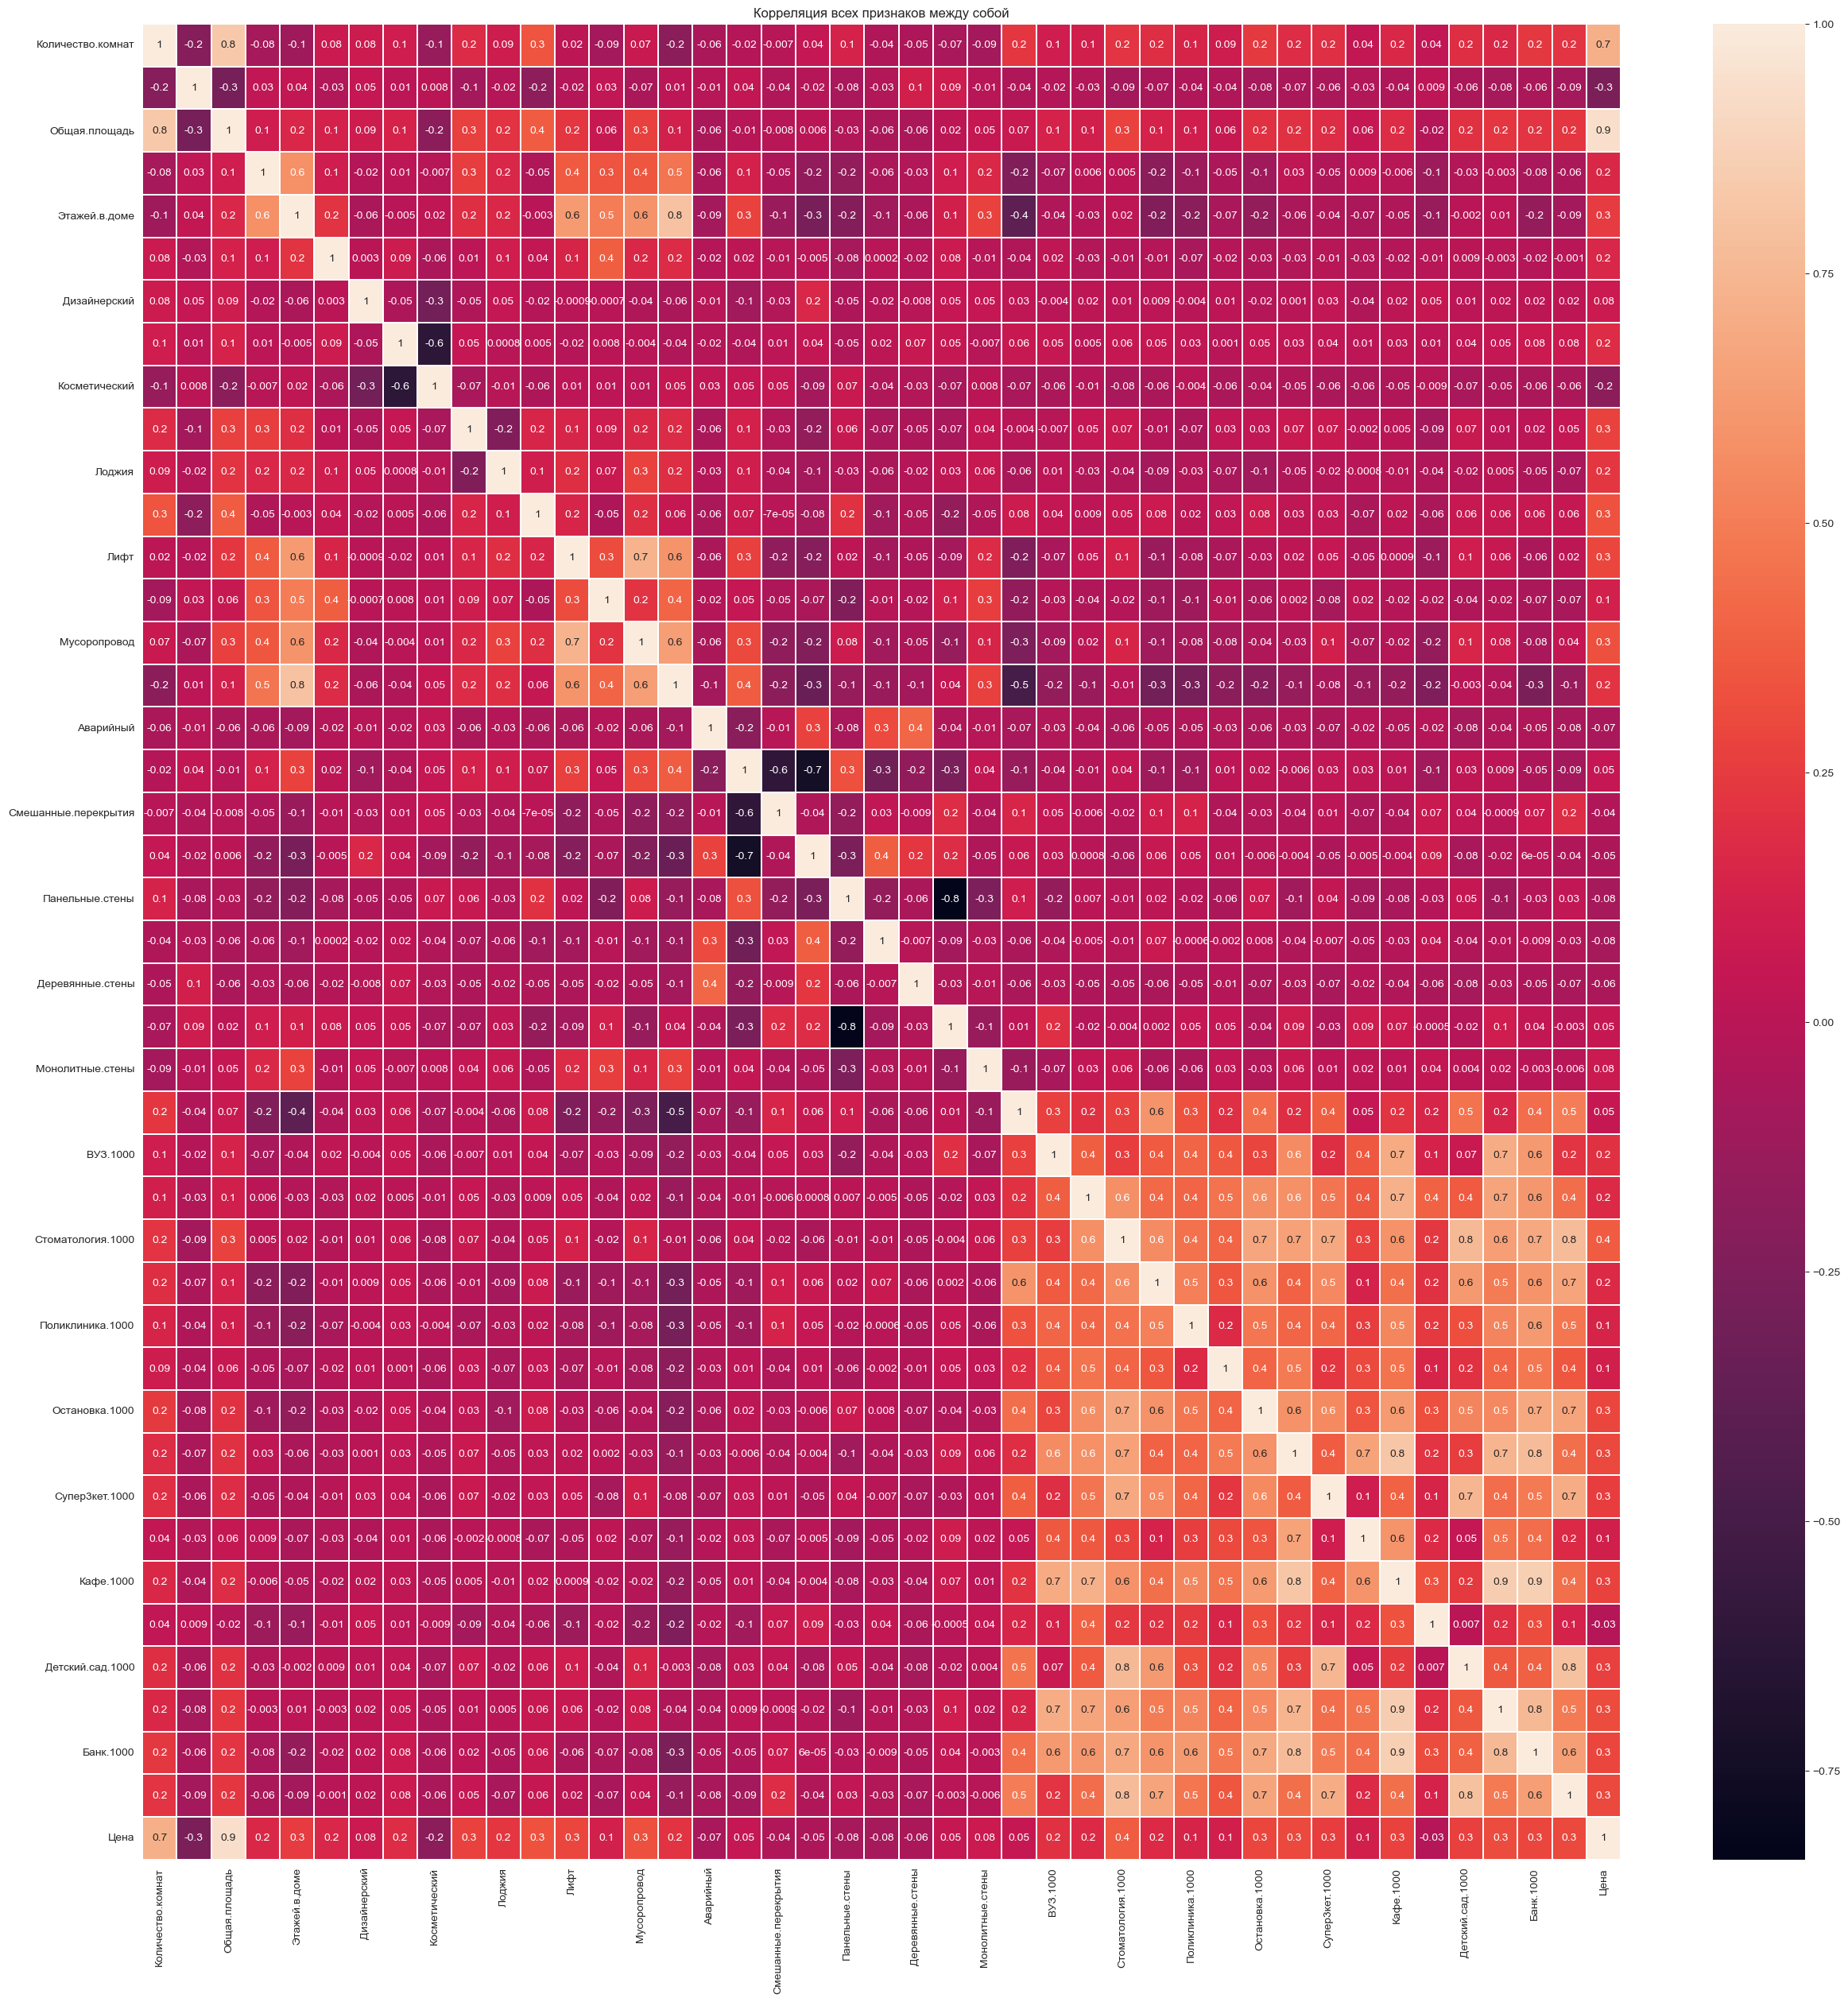

In [70]:
sb.heatmap(
    train_data.corr(),
    annot=True,
    linewidths=0.2,
    fmt='.1g',
)
fig = plt.gcf()
fig.set_size_inches(30, 30)
plt.title("Корреляция всех признаков между собой")
plt.show()

In [75]:
def show_correlation(names):
    corr_price_df = train_data.corr()[['Цена']].transpose()[names]
    sb.heatmap(
    corr_price_df,
    annot=True,
    fmt='.1g',
    )
    fig = plt.gcf()
    fig.set_size_inches(35, 5)

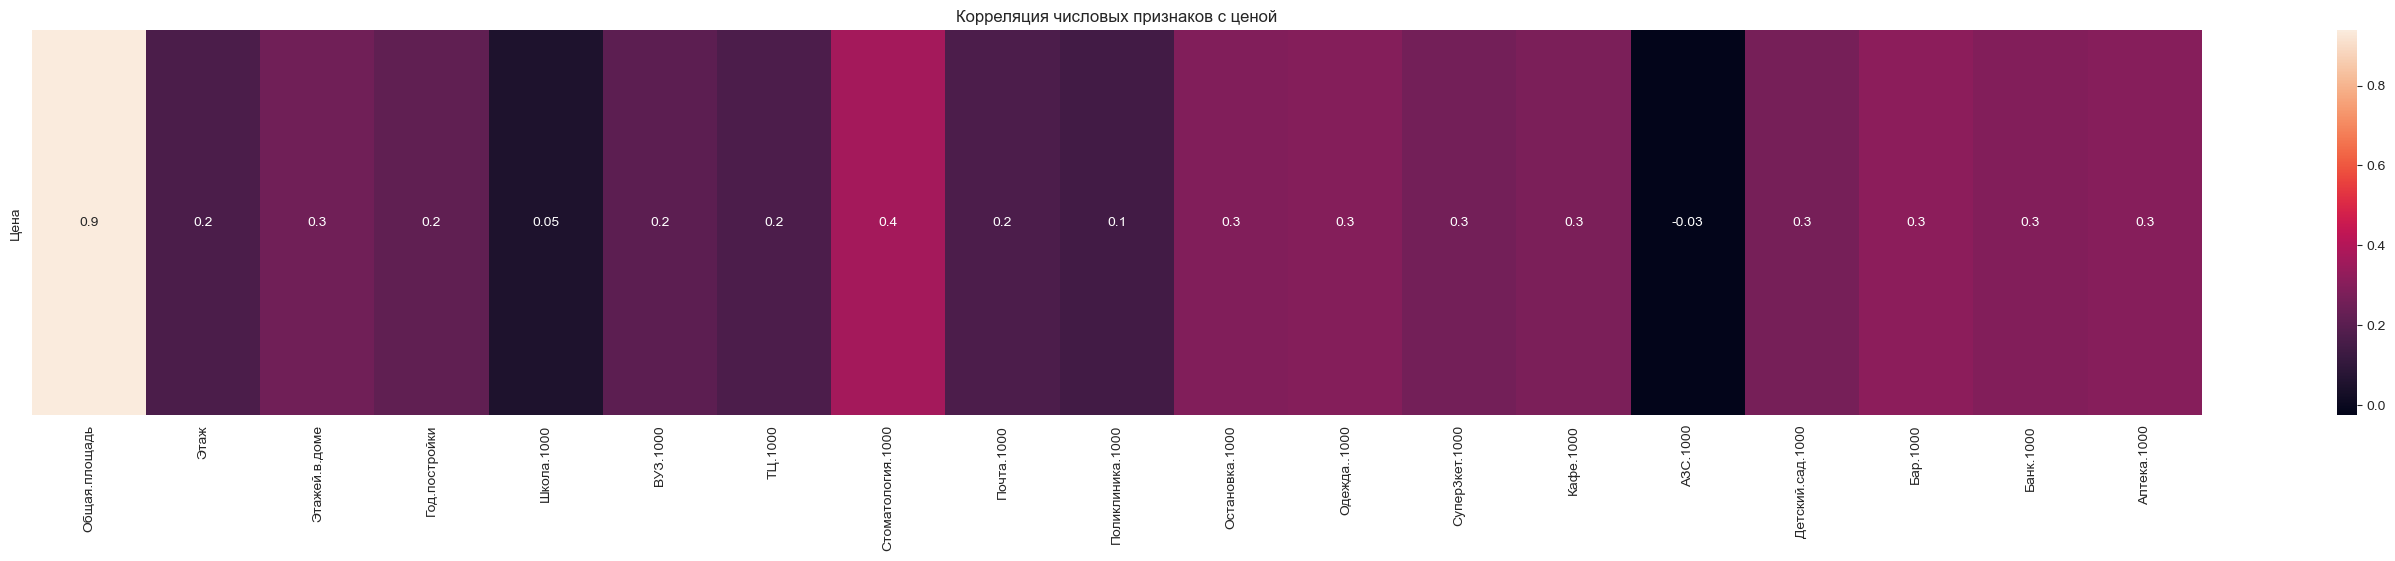

In [76]:
show_correlation(numeric)
plt.title("Корреляция числовых признаков с ценой")
plt.show()

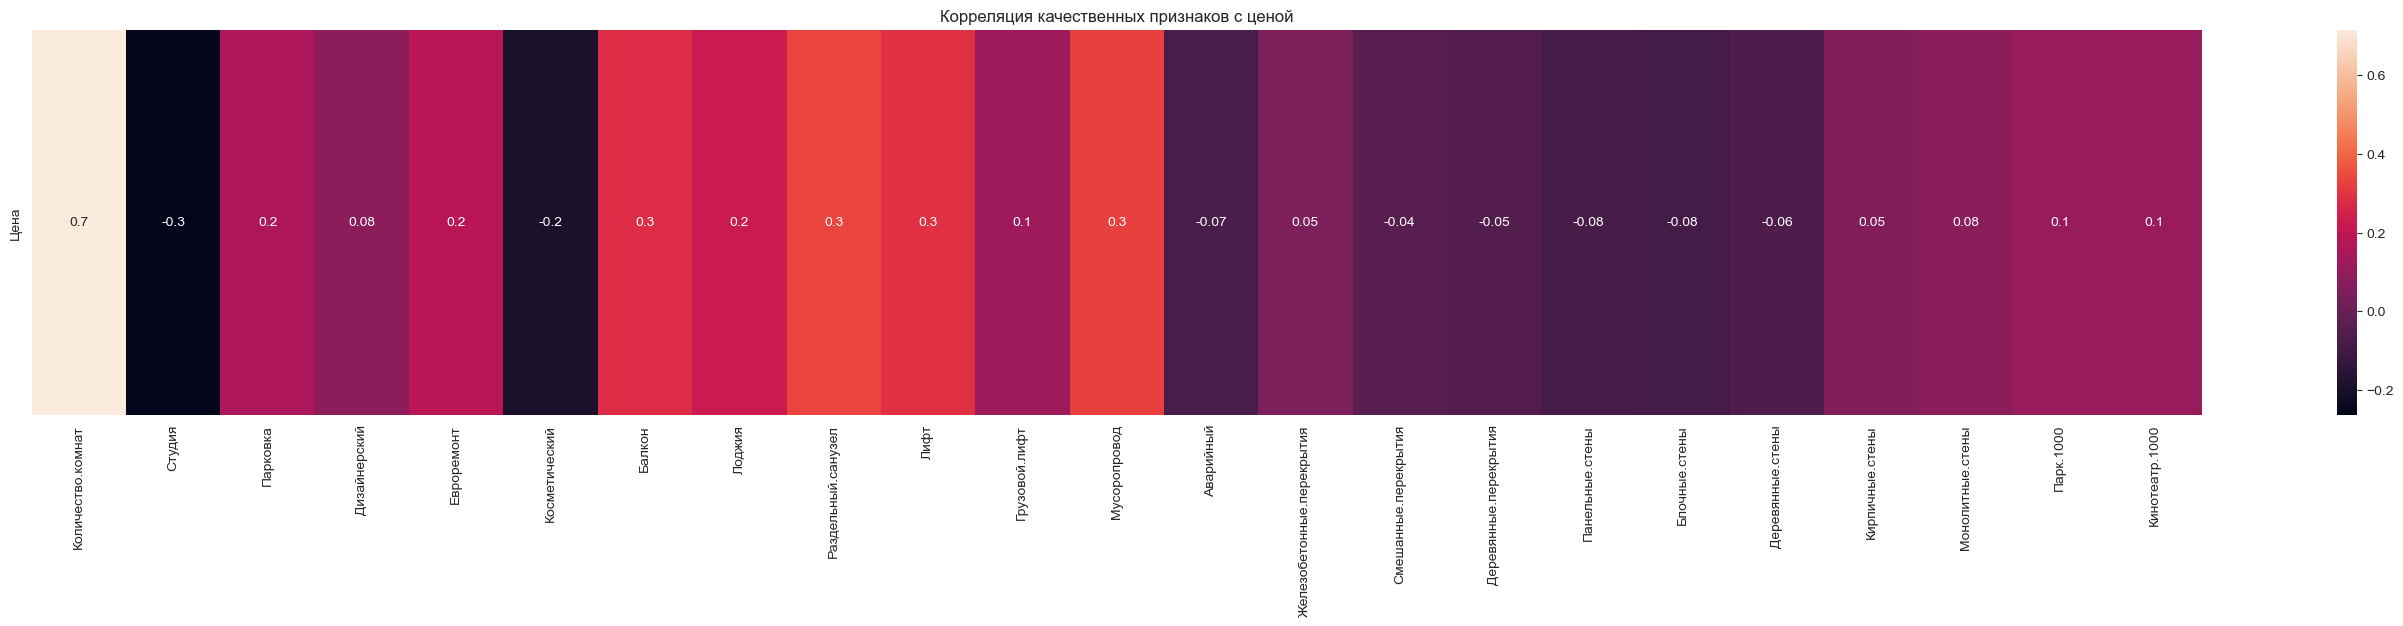

In [77]:
show_correlation(categorical)
plt.title("Корреляция качественных признаков с ценой")
plt.show()

Определим наиболее значимые признаки

In [80]:
x = train_data[columns]
y = train_data[answer]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)
def find_features(method):
    """
    Определяет наиболее значимые признаки модели
    @:param method: способ выбора признаков
    @:return: имена значимых признаков
    """
    values = method.fit(x, y)
    selected_features_names = values.get_feature_names_out()
    print("Top features: ", end="")
    print(selected_features_names)
    return selected_features_names

selector = SelectFromModel(LinearRegression())
features = find_features(selector)

Top features: ['Общая.площадь' 'ВУЗ.1000' 'ТЦ.1000' 'Стоматология.1000' 'Остановка.1000'
 'Кафе.1000' 'Бар.1000' 'Банк.1000' 'Евроремонт']


Удалим все незначимые признаки

In [84]:
train_data = train_data.loc[:, np.append(features, answer)]
test_data = test_data.loc[:, features]
df_all = features

x = train_data[df_all]
y = train_data[answer]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Общая.площадь      808 non-null    float64
 1   ВУЗ.1000           808 non-null    float64
 2   ТЦ.1000            808 non-null    float64
 3   Стоматология.1000  808 non-null    float64
 4   Остановка.1000     808 non-null    float64
 5   Кафе.1000          808 non-null    float64
 6   Бар.1000           808 non-null    float64
 7   Банк.1000          808 non-null    float64
 8   Евроремонт         808 non-null    int64  
 9   Цена               808 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 63.2 KB


## Построение регрессионных моделей

In [99]:
def aic(len_data_frame: int, mse: float, num_params: int) -> float:
    """Вычисление информационного критерия Акаике."""
    return 2 * num_params + len_data_frame * log(mse)


def bic(len_data_frame: int, mse: float, num_params: int) -> float:
    """Вычисление байесовского информационного критерия."""
    return num_params * log(len_data_frame) + len_data_frame * log(mse)

def search_info(
    model,
    name_model: str,
    params: dict,
    list_models=[],
) -> None:
    """Поиск подходящих параметров и вывод информации о модели."""
    gs = GridSearchCV(
        model,
        params,
        cv=5,
        n_jobs=-1,
        scoring="neg_mean_squared_error",
    )
    gs.fit(x_train, y_train)
    best_model = gs.best_estimator_
    print(f"Модель: {best_model}")
    y_pred = best_model.predict(x_test)
    rmse_value = mean_squared_error(y_test, y_pred, squared=False)
    try:
        num_params = len(best_model.coef_) + 1
    except:
        num_params = len(train_data)
    r2_value = r2_score(y_test, y_pred)
    aic_value = aic(
        len(y_test),
        mean_squared_error(y_test, y_pred, squared=True),
        num_params,
    )
    bic_value = bic(
        len(y_test),
        mean_squared_error(y_test, y_pred, squared=True),
        num_params,
    )
    print(f'RMSE: {rmse_value}')
    print(f'Score == R2: {r2_value}')
    print(f"BIC: {bic_value}")
    print(f"AIC: {aic_value}")
    list_models.append(
        [name_model, best_model, rmse_value, r2_value, bic_value, aic_value]
    )

### Линейная регрессия

In [90]:
linear_parameters = {}
search_info(
    LinearRegression(),
    "Линейная модель",
    linear_parameters,
)

Наилучшая полученная модель: LinearRegression()
RMSE: 318479.4266332412
Score == R2: 0.8956052131736537
BIC: 6213.188808905468
AIC: 6178.258194472063


### Лассо регрессия

In [92]:
search_info(
    Lasso(),
    "Линейная модель",
    linear_parameters,
)

Наилучшая полученная модель: Lasso()
RMSE: 318476.32649450493
Score == R2: 0.8956072455608051
BIC: 6213.184078066886
AIC: 6178.253463633481


### Гребневая регрессия

In [94]:
search_info(
    Ridge(),
    "Линейная модель",
    linear_parameters,
)

Наилучшая полученная модель: Ridge()
RMSE: 325334.55081290414
Score == R2: 0.8910627462470657
BIC: 6223.538743454234
AIC: 6188.608129020828


### Elastic-Net

In [96]:
search_info(
    ElasticNet(),
    "Линейная модель",
    linear_parameters,
)

Наилучшая полученная модель: ElasticNet()
RMSE: 925489.0060523353
Score == R2: 0.11842640309755093
BIC: 6731.636294984117
AIC: 6696.705680550712


### Метод наименьших углов

In [98]:
search_info(
    Lars(),
    "Линейная модель",
    linear_parameters,
)

Наилучшая полученная модель: Lars()
RMSE: 318479.42663324106
Score == R2: 0.8956052131736538
BIC: 6213.188808905468
AIC: 6178.258194472063
